Copyright (C) 2023 - 2024 ANSYS, Inc. and/or its affiliates.
SPDX-License-Identifier: MIT


Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## EDB: 5G linear array antenna

This example shows how you can use HFSS 3D Layout to create and solve a 5G linear array antenna.

## Perform required imports

Perform required imports.

In [1]:
import os
import tempfile

In [2]:
from ansys.aedt.core import Hfss3dLayout

In [3]:
import pyedb
from pyedb.generic.general_methods import generate_unique_name

## Set non-graphical mode

Set non-graphical mode. The default is ``False``.

In [4]:
non_graphical = False

In [5]:
class Patch:
    def __init__(self, width=0.0, height=0.0, position=0.0):
        self.width = width
        self.height = height
        self.position = position

    @property
    def points(self):
        return [
            [self.position, -self.height / 2],
            [self.position + self.width, -self.height / 2],
            [self.position + self.width, self.height / 2],
            [self.position, self.height / 2],
        ]

In [6]:
class Line:
    def __init__(self, length=0.0, width=0.0, position=0.0):
        self.length = length
        self.width = width
        self.position = position

    @property
    def points(self):
        return [
            [self.position, -self.width / 2],
            [self.position + self.length, -self.width / 2],
            [self.position + self.length, self.width / 2],
            [self.position, self.width / 2],
        ]

In [7]:
class LinearArray:
    def __init__(self, nb_patch=1, array_length=10e-3, array_width=5e-3):
        self.nbpatch = nb_patch
        self.length = array_length
        self.width = array_width

    @property
    def points(self):
        return [
            [-1e-3, -self.width / 2 - 1e-3],
            [self.length + 1e-3, -self.width / 2 - 1e-3],
            [self.length + 1e-3, self.width / 2 + 1e-3],
            [-1e-3, self.width / 2 + 1e-3],
        ]

In [8]:
tmpfold = tempfile.gettempdir()
aedb_path = os.path.join(tmpfold, generate_unique_name("pcb") + ".aedb")
print(aedb_path)
edb = pyedb.Edb(edbpath=aedb_path, edbversion="2024.2")

C:\Users\ansys\AppData\Local\Temp\pcb_0RI1W4.aedb


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: EDB C:\Users\ansys\AppData\Local\Temp\pcb_0RI1W4.aedb created correctly.


PyAEDT INFO: EDB initialized.


In [9]:
# ## Add stackup layers
#
# Add the stackup layers.
layers = {
    "TOP": {"type": "signal", "thicness": "35um", "material": "copper"},
    "Substrat": {"type": "dielectric", "thicness": "0.5mm", "material": "Duroid (tm)"},
    "GND": {"type": "signal", "thicness": "35um", "material": "copper"},
    "Gap": {"type": "dielectric", "thicness": "0.05mm", "material": "Air"},
    "Virt_GND": {"type": "signal", "thicness": "35um", "material": "copper"},
}

In [10]:
edb.stackup.load(layers)

PyAEDT INFO: Configuration file does not have material definition. Using aedb and syslib materials.


True

## Create linear array

Create the first patch of the linear array.

In [11]:
first_patch = Patch(width=1.4e-3, height=1.2e-3, position=0.0)
edb.modeler.create_polygon(first_patch.points, "TOP", net_name="Array_antenna")
# First line
first_line = Line(length=2.4e-3, width=0.3e-3, position=first_patch.width)
edb.modeler.create_polygon(first_line.points, "TOP", net_name="Array_antenna")

## Patch linear array

Patch the linear array.

In [12]:
patch = Patch(width=2.29e-3, height=3.3e-3)
line = Line(length=1.9e-3, width=0.2e-3)
linear_array = LinearArray(nb_patch=8, array_width=patch.height)

In [13]:
current_patch = 1
current_position = first_line.position + first_line.length

In [14]:
while current_patch <= linear_array.nbpatch:
    patch.position = current_position
    edb.modeler.create_polygon(patch.points, "TOP", net_name="Array_antenna")
    current_position += patch.width
    if current_patch < linear_array.nbpatch:
        line.position = current_position
        edb.modeler.create_polygon(line.points, "TOP", net_name="Array_antenna")
        current_position += line.length
    current_patch += 1

In [15]:
linear_array.length = current_position

## Add ground

Add a ground.

In [16]:
edb.modeler.create_polygon(linear_array.points, "GND", net_name="GND")

## Add connector pin

Add a central connector pin.

In [17]:
edb.padstacks.create(padstackname="Connector_pin", holediam="100um", paddiam="0", antipaddiam="200um")
con_pin = edb.padstacks.place(
    [first_patch.width / 4, 0],
    "Connector_pin",
    net_name="Array_antenna",
    fromlayer="TOP",
    tolayer="GND",
    via_name="coax",
)

PyAEDT INFO: Padstack Connector_pin create correctly


## Add connector ground

Add a connector ground.

In [18]:
edb.modeler.create_polygon(first_patch.points, "Virt_GND", net_name="GND")
edb.padstacks.create("gnd_via", "100um", "0", "0")
con_ref1 = edb.padstacks.place(
    [first_patch.points[0][0] + 0.2e-3, first_patch.points[0][1] + 0.2e-3],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref2 = edb.padstacks.place(
    [first_patch.points[1][0] - 0.2e-3, first_patch.points[1][1] + 0.2e-3],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref3 = edb.padstacks.place(
    [first_patch.points[2][0] - 0.2e-3, first_patch.points[2][1] - 0.2e-3],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref4 = edb.padstacks.place(
    [first_patch.points[3][0] + 0.2e-3, first_patch.points[3][1] - 0.2e-3],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)

PyAEDT INFO: Padstack gnd_via create correctly


## Add excitation port

Add an excitation port.

In [19]:
edb.padstacks.set_solderball(con_pin, "Virt_GND", isTopPlaced=False, ballDiam=0.1e-3)
port_name = edb.padstacks.create_coax_port(con_pin)

## Plot geometry

Plot the geometry.

PyAEDT INFO: Plot Generation time 0.125


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

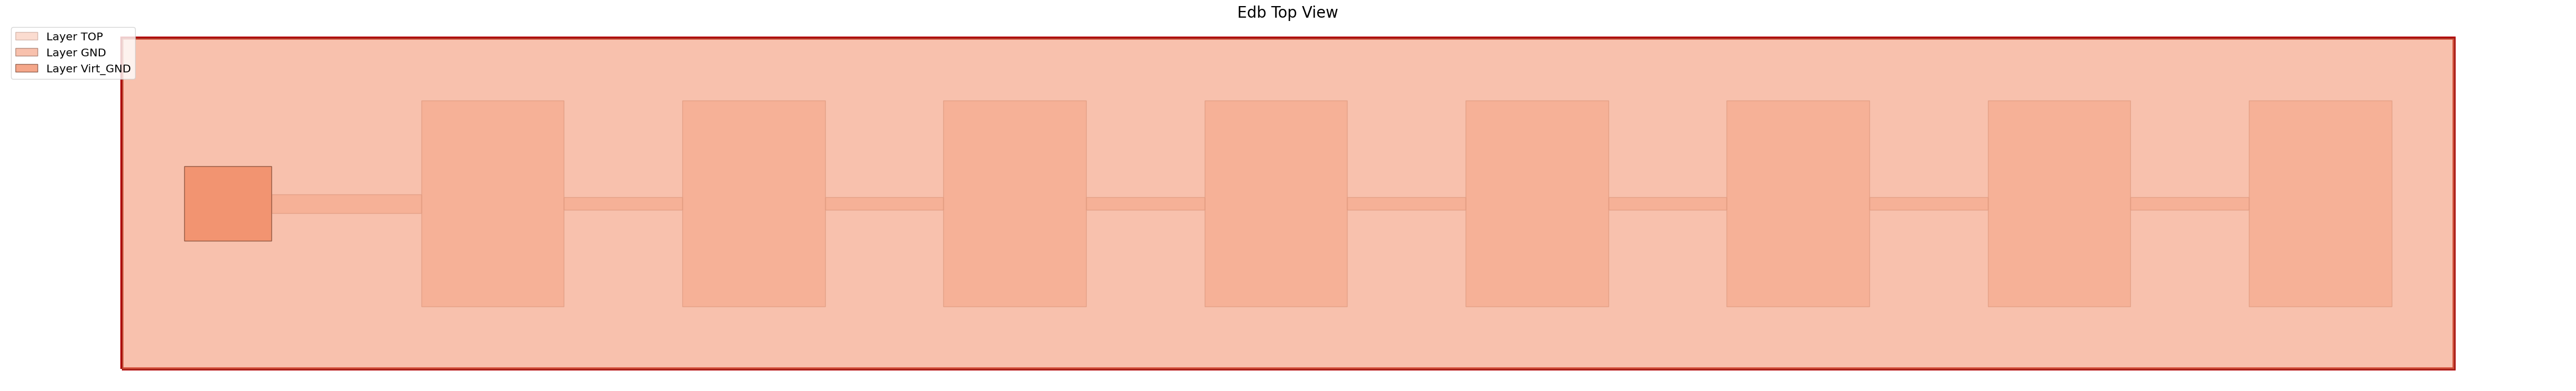

In [20]:
edb.nets.plot(None)

## Save and close Edb instance prior to opening it in Electronics Desktop.

Save EDB.

In [21]:
edb.save_edb()
edb.close_edb()
print("EDB saved correctly to {}. You can import in AEDT.".format(aedb_path))

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 0.00ms


EDB saved correctly to C:\Users\ansys\AppData\Local\Temp\pcb_0RI1W4.aedb. You can import in AEDT.


## Launch HFSS 3D Layout and open EDB

Launch HFSS 3D Layout and open EDB.

In [22]:
h3d = Hfss3dLayout(
    projectname=aedb_path, specified_version="2024.2", new_desktop_session=True, non_graphical=non_graphical
)

PyAEDT WARNING: Argument `projectname` is deprecated for method `__init__`; use `project` instead.


PyAEDT WARNING: Argument `specified_version` is deprecated for method `__init__`; use `version` instead.


PyAEDT WARNING: Argument `new_desktop_session` is deprecated for method `__init__`; use `new_desktop` instead.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.14.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_2dab7d5b-daa0-4b3c-862f-f39a3e57c32f.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 52638


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1280.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\pcb_0RI1W4.aedb has been imported to project pcb_0RI1W4


PyAEDT INFO: Active Design set to 0;Cell_2LINS0


PyAEDT INFO: Aedt Objects correctly read


## Plot geometry

Plot the geometry. The EDB methods are also accessible from the ``Hfss3dlayout`` class.

PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database pcb_0RI1W4.aedb Opened in 2024.2


PyAEDT INFO: Cell Cell_2LINS0 Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Plot Generation time 0.111


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

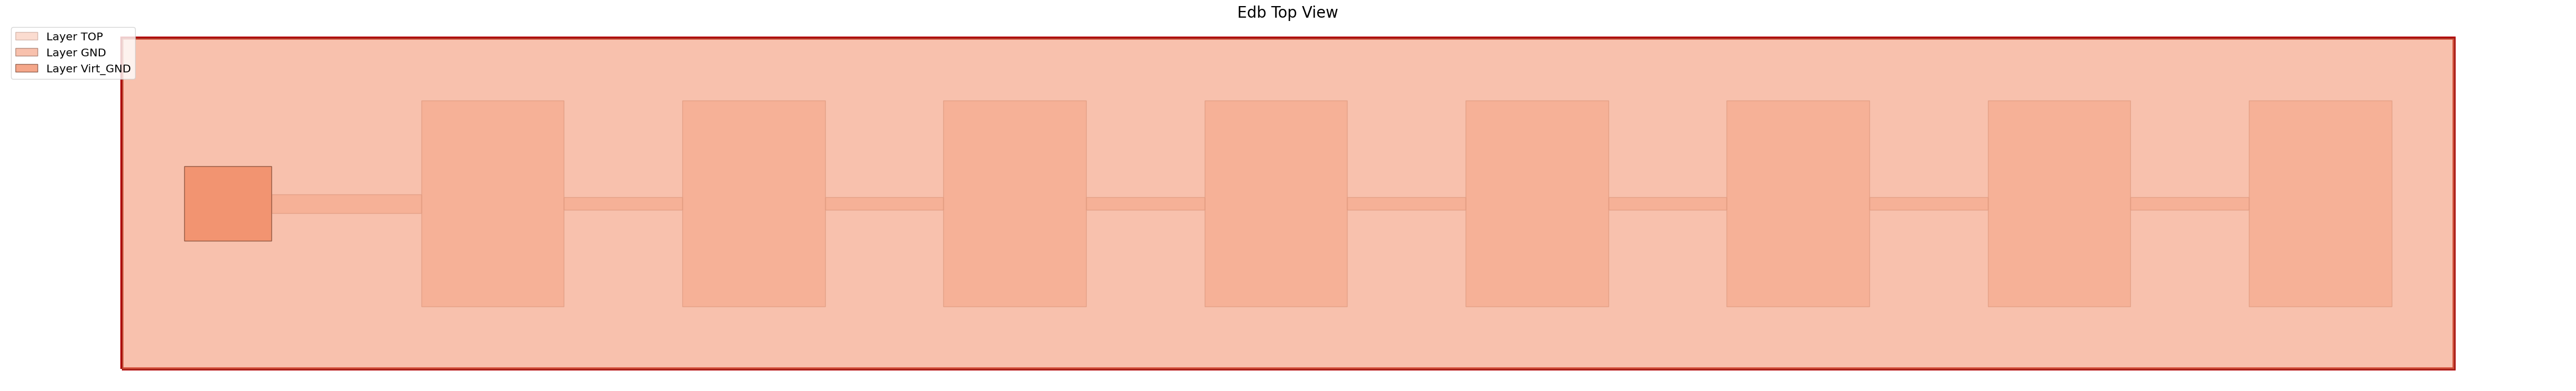

In [23]:
h3d.modeler.edb.nets.plot(None)

## Create setup and sweeps

Getters and setters facilitate the settings on the nested property dictionary.
Previously, you had to use these commands:

``setup.props["AdaptiveSettings"]["SingleFrequencyDataList"]["AdaptiveFrequencyData"]["AdaptiveFrequency"] = "20GHz"``
``setup.props["AdaptiveSettings"]["SingleFrequencyDataList"]["AdaptiveFrequencyData"]["MaxPasses"] = 4``

You can now use the simpler approach that follows.

In [24]:
setup = h3d.create_setup()

In [25]:
setup["AdaptiveFrequency"] = "20GHz"
setup["AdaptiveSettings/SingleFrequencyDataList/AdaptiveFrequencyData/MaxPasses"] = 4
h3d.create_linear_count_sweep(
    setupname=setup.name,
    unit="GHz",
    freqstart=20,
    freqstop=50,
    num_of_freq_points=1001,
    sweepname="sweep1",
    sweep_type="Interpolating",
    interpolation_tol_percent=1,
    interpolation_max_solutions=255,
    save_fields=False,
    use_q3d_for_dc=False,
)

PyAEDT WARNING: Argument `setupname` is deprecated for method `create_linear_count_sweep`; use `setup` instead.


PyAEDT WARNING: Argument `freqstart` is deprecated for method `create_linear_count_sweep`; use `start_frequency` instead.


PyAEDT WARNING: Argument `freqstop` is deprecated for method `create_linear_count_sweep`; use `stop_frequency` instead.


PyAEDT WARNING: Argument `sweepname` is deprecated for method `create_linear_count_sweep`; use `name` instead.


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/pcb_0RI1W4.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/pcb_0RI1W4.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015623331069946289


PyAEDT INFO: Linear count sweep sweep1 has been correctly created.


## Solve setup and create report

Solve the project and create a report.

In [26]:
h3d.analyze()
h3d.post.create_report(["db(S({0},{1}))".format(port_name, port_name)])

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 27.0s


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


## Plot results outside AEDT

Plot results using Matplotlib.

PyAEDT INFO: Solution Data Correctly Loaded.


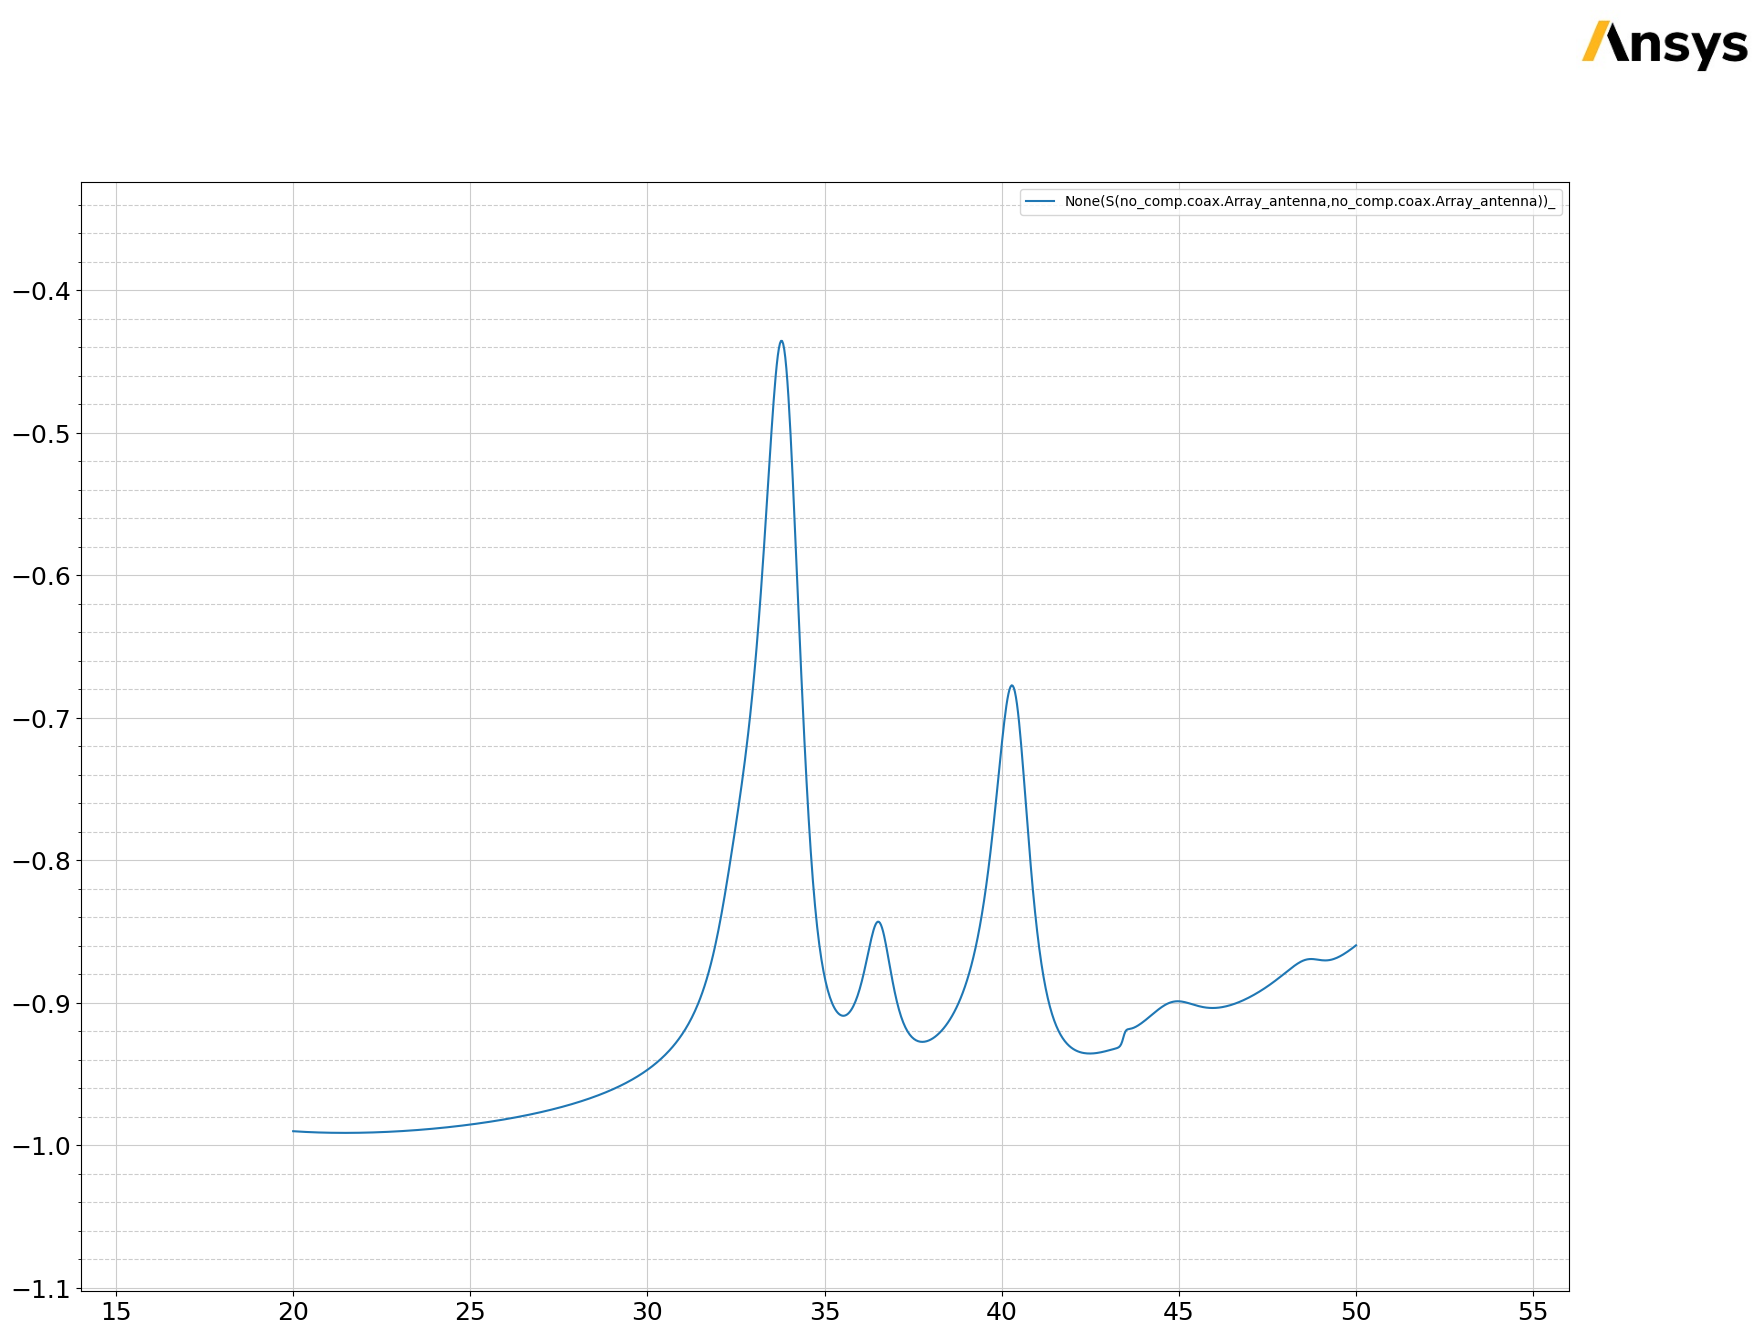

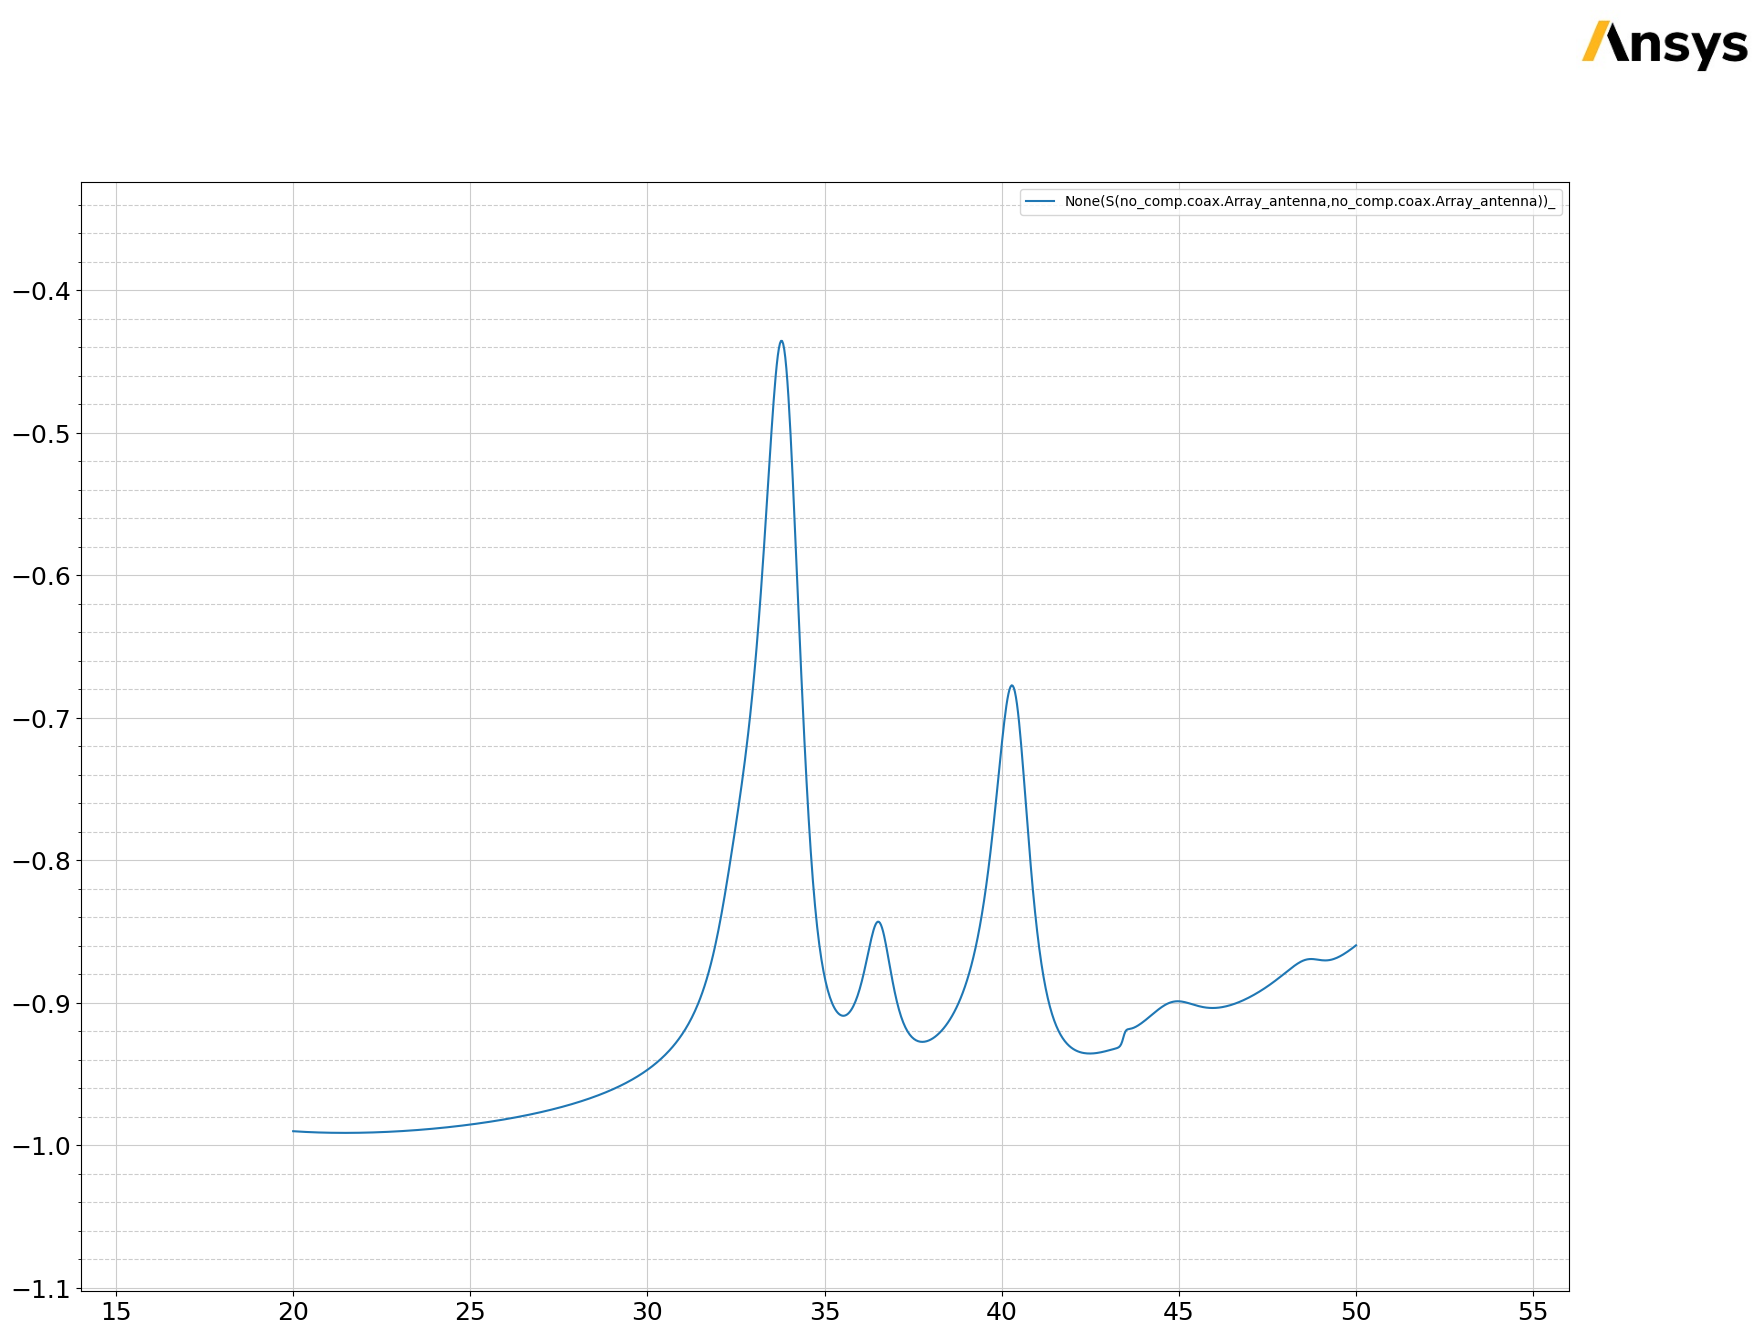

In [27]:
solution = h3d.post.get_solution_data(["S({0},{1})".format(port_name, port_name)])
solution.plot()

## Close AEDT

After the simulation completes, you can close AEDT or release it using the
:func:`dotnet.Desktop.release_desktop` method.
All methods provide for saving the project before closing AEDT.

In [28]:
h3d.save_project()
h3d.release_desktop()

PyAEDT INFO: Project pcb_0RI1W4 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


True